In [1]:
import pandas as pd
import numpy as np
import logging
import scipy.signal as scs
import src
import smile_extract
logging.basicConfig(level=logging.INFO)

monkey = 'Prez'
date = '2022-07-21'
path = f'../data/trialframe/{monkey}/{date}/{monkey}_{date}_tf.parquet'
tf = pd.read_parquet(path)
tf

channel                         monkey session date    block  \
signal                                                         
trial_id time                                                  
1        0 days 00:00:00          Prez   2022-07-21  cst-rtt   
         0 days 00:00:00.010000   Prez   2022-07-21  cst-rtt   
         0 days 00:00:00.020000   Prez   2022-07-21  cst-rtt   
         0 days 00:00:00.030000   Prez   2022-07-21  cst-rtt   
         0 days 00:00:00.040000   Prez   2022-07-21  cst-rtt   
...                                ...          ...      ...   
400      0 days 00:00:05.950000   Prez   2022-07-21  cst-rtt   
         0 days 00:00:05.960000   Prez   2022-07-21  cst-rtt   
         0 days 00:00:05.970000   Prez   2022-07-21  cst-rtt   
         0 days 00:00:05.980000   Prez   2022-07-21  cst-rtt   
         0 days 00:00:05.990000   Prez   2022-07-21  cst-rtt   

channel                              trial datetime task   result  \
signal                                                              
trial_id time                                                       
1        0 days 00:00:00        2022-07-21 08:28:01  CST  success   
         0 days 00:00:00.010000 2022-07-21 08:28:01  CST  success   
         0 days 00:00:00.020000 2022-07-21 08:28:01  CST  success   
         0 days 00:00:00.030000 2022-07-21 08:28:01  CST  success   
         0 days 00:00:00.040000 2022-07-21 08:28:01  CST  success   
...                                             ...  ...      ...   
400      0 days 00:00:05.950000 2022-07-21 09:18:06  RTT  failure   
         0 days 00:00:05.960000 2022-07-21 09:18:06  RTT  failure   
         0 days 00:00:05.970000 2022-07-21 09:18:06  RTT  failure   
         0 days 00:00:05.980000 2022-07-21 09:18:06  RTT  failure   
         0 days 00:00:05.990000 2022-07-21 09:18:06  RTT  failure   

channel                                    state hand position              \
signal                                                       x           y   
trial_id time                                                                
1        0 days 00:00:00         Reach to Center     87.491912  619.951447   
         0 days 00:00:00.010000  Reach to Center     87.469056  619.949176   
         0 days 00:00:00.020000  Reach to Center     87.439185  619.957786   
         0 days 00:00:00.030000  Reach to Center     87.415315  619.952311   
         0 days 00:00:00.040000  Reach to Center     87.402561  619.936980   
...                                          ...           ...         ...   
400      0 days 00:00:05.950000   Center Failure    269.959956  589.363515   
         0 days 00:00:05.960000   Center Failure    269.958383  589.363922   
         0 days 00:00:05.970000   Center Failure    269.954549  589.368569   
         0 days 00:00:05.980000   Center Failure    269.952290  589.373188   
         0 days 00:00:05.990000   Center Failure    269.954555  589.378552   

channel                                      ... motor cortex                  \
signal                                    z  ...      ch121u2 ch122u1 ch123u1   
trial_id time                                ...                                
1        0 days 00:00:00        -130.308794  ...            0       0       0   
         0 days 00:00:00.010000 -130.281867  ...            0       0       0   
         0 days 00:00:00.020000 -130.279259  ...            0       0       0   
         0 days 00:00:00.030000 -130.301029  ...            0       0       0   
         0 days 00:00:00.040000 -130.306830  ...            0       0       0   
...                                     ...  ...          ...     ...     ...   
400      0 days 00:00:05.950000 -222.739631  ...            0       0       0   
         0 days 00:00:05.960000 -222.746128  ...            1       0       1   
         0 days 00:00:05.970000 -222.740542  ...            1       0       0   
         0 days 00:00:05.980000 -222.739822  ...            1       0  

In [2]:
def estimate_kinematic_derivative(df: pd.DataFrame, deriv: int = 1, cutoff: float = 30):
    # assert that columns are not a multiindex, so we know we're working with one "signal"
    assert not isinstance(df.columns, pd.MultiIndex), 'must work with only one "signal"'
    assert deriv == 1, 'only first derivative is supported currently'

    sample_spacing = (
        src.munge.get_index_level(df, 'time')
        .diff()
        .value_counts()
        .idxmax()
        .total_seconds()
    )
    samprate = 1/sample_spacing
    filt_b, filt_a = scs.butter(4, cutoff / (samprate / 2), 'low')
    return (
        df
        .groupby('trial_id', group_keys=False)
        .apply(lambda x: pd.DataFrame(
            scs.filtfilt(filt_b, filt_a, x.values, axis=0),
            columns=x.columns,
            index=x.index
        ))
        .groupby('trial_id', group_keys=False)
        .apply(lambda x: pd.DataFrame(
            np.gradient(x.values, sample_spacing, axis=0),
            columns=x.columns,
            index=x.index
        ))
    )

(
    tf
    .set_index(['task','result','state'],append=True)
    [['hand position','motor cortex']]
    .pipe(src.munge.hierarchical_assign, {
        'hand velocity': lambda df: estimate_kinematic_derivative(df['hand position'], deriv=1, cutoff=30),
    })
)
# (
#     tf
#     ['hand position']
#     .pipe(estimate_kinematic_derivative, deriv=1, cutoff=30)
# )

hand position  \
                                                                         x   
trial_id time                   task result  state                           
1        0 days 00:00:00        CST  success Reach to Center     87.491912   
         0 days 00:00:00.010000 CST  success Reach to Center     87.469056   
         0 days 00:00:00.020000 CST  success Reach to Center     87.439185   
         0 days 00:00:00.030000 CST  success Reach to Center     87.415315   
         0 days 00:00:00.040000 CST  success Reach to Center     87.402561   
...                                                                    ...   
400      0 days 00:00:05.950000 RTT  failure Center Failure     269.959956   
         0 days 00:00:05.960000 RTT  failure Center Failure     269.958383   
         0 days 00:00:05.970000 RTT  failure Center Failure     269.954549   
         0 days 00:00:05.980000 RTT  failure Center Failure     269.952290   
         0 days 00:00:05.990000 RTT  failure Center Failure     269.954555   

                                                                          \
                                                                       y   
trial_id time                   task result  state                         
1        0 days 00:00:00        CST  success Reach to Center  619.951447   
         0 days 00:00:00.010000 CST  success Reach to Center  619.949176   
         0 days 00:00:00.020000 CST  success Reach to Center  619.957786   
         0 days 00:00:00.030000 CST  success Reach to Center  619.952311   
         0 days 00:00:00.040000 CST  success Reach to Center  619.936980   
...                                                                  ...   
400      0 days 00:00:05.950000 RTT  failure Center Failure   589.363515   
         0 days 00:00:05.960000 RTT  failure Center Failure   589.363922   
         0 days 00:00:05.970000 RTT  failure Center Failure   589.368569   
         0 days 00:00:05.980000 RTT  failure Center Failure   589.373188   
         0 days 00:00:05.990000 RTT  failure Center Failure   589.378552   

                                                                          \
                                                                       z   
trial_id time                   task result  state                         
1        0 days 00:00:00        CST  success Reach to Center -130.308794   
         0 days 00:00:00.010000 CST  success Reach to Center -130.281867   
         0 days 00:00:00.020000 CST  success Reach to Center -130.279259   
         0 days 00:00:00.030000 CST  success Reach to Center -130.301029   
         0 days 00:00:00.040000 CST  success Reach to Center -130.306830   
...                                                                  ...   
400      0 days 00:00:05.950000 RTT  failure Center Failure  -222.739631   
         0 days 00:00:05.960000 RTT  failure Center Failure  -222.746128   
         0 days 00:00:05.970000 RTT  failure Center Failure  -222.740542   
         0 days 00:00:05.980000 RTT  failure Center Failure  -222.739822   
         0 days 00:00:05.990000 RTT  failure Center Failure  -222.746601   

                                                             motor cortex  \
                                                                    ch1u1   
trial_id time                   task result  state                          
1        0 days 00:00:00        CST  success Reach to Center            1   
         0 days 00:00:00.010000 CST  success Reach to Center            0   
         0 days 00:00:00.020000 CST  success Reach to Center            1   
         0 days 00:00:00.030000 CST  success Reach to Center            0   
         0 days 00:00:00.040000 CST  success Reach to Center            0   
...                                                                   ...   
400      0 days 00:00:05.950000 RTT  failure Center Failure             0   
         0 days 00:00:05.960000 RTT  failure Center Failure         

In [3]:
state_mapper = {
    'Control System': 'Go Cue',
    'Reach to Target 1': 'Go Cue',
    'Hold at Target 1': 'Go Cue', # Sometimes first reach state is skipped in this table (if the first target is in the center)
}
preproc = (
    tf
    .set_index(['task','result','state'],append=True)
    [['hand position','motor cortex']]
    .pipe(src.munge.multivalue_xs,keys=['CST','RTT'],level='task')
    .xs(level='result',key='success')
    .rename(index=state_mapper, level='state')
    .groupby('trial_id', group_keys=False)
    .apply(src.time_slice.reindex_trial_from_event, event='Go Cue')
)
trim_pipeline = lambda df: (
    df
    .loc[(slice(None),slice('-0.5 sec','3sec')),:]
)

neural_data = (
    preproc
    ['motor cortex']
    .groupby('trial_id')
    .transform(smile_extract.smooth_data, dt=0.01,std=0.1,backend='convolve')
    .pipe(src.crystal_models.SoftnormScaler().fit_transform)
    .pipe(trim_pipeline)
)

hand_data = (
    preproc
    ['hand position']
    .pipe(estimate_kinematic_derivative, deriv=1, cutoff=30)
    .pipe(trim_pipeline)
)


In [4]:
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

model = LinearRegression()
cross_val_score(
    model,
    neural_data,
    hand_data['x'],
    cv=GroupKFold(n_splits=5),
    groups=hand_data.index.get_level_values('trial_id'),
)

array([0.70530958, 0.68283101, 0.70400173, 0.62527111, 0.67020341])

<Axes: xlabel='Train data', ylabel='Test data'>

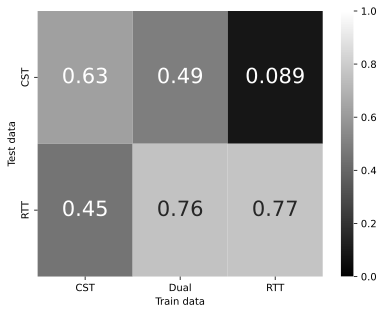

In [5]:
import src.decoding
import seaborn as sns
temp = (
    pd.concat(
        [hand_data,neural_data],
        axis=1,
        keys=['hand velocity','motor cortex']
    )
    .assign(**{
        'Test labels': lambda df: src.decoding.get_test_labels(df,test_size=0.25),
    })
    .set_index('Test labels',append=True)
)

models = src.decoding.fit_models(
    temp.xs(level='Test labels',key=False),
    signal_name='motor cortex',
    target_name=('hand velocity','x'),
    sample_size=10000,
)
scores = src.decoding.score_models(
    temp.xs(level='Test labels',key=True),
    signal_name='motor cortex',
    target_name=('hand velocity','x'),
    models=models,
)
trial_scores = src.decoding.score_trials(
    temp.xs(level='Test labels',key=True),
    signal_name='motor cortex',
    target_name=('hand velocity','x'),
    models=models,
)
sns.heatmap(
    data=scores.unstack(),
    vmin=0,
    vmax=1,
    annot=True,
    annot_kws={'fontsize': 21},
    cmap='gray',
)

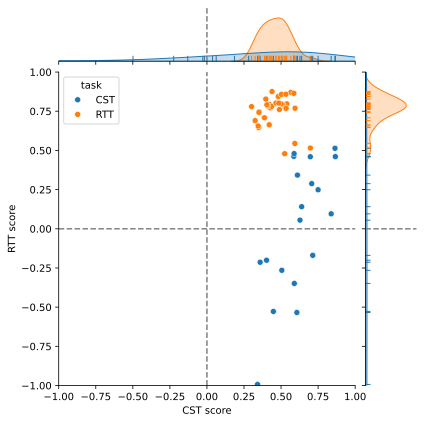

In [7]:
single_trial_scatter = sns.jointplot(
    data=trial_scores.reset_index(),
    y='RTT score',
    x='CST score',
    hue='task',
    hue_order=['CST','RTT'],
    palette=['C0','C1'],
    xlim=(-1,1),
    ylim=(-1,1),
    marginal_ticks=False,
)
single_trial_scatter.plot_marginals(sns.rugplot,height=0.1,palette=['C0','C1'])
single_trial_scatter.refline(x=0,y=0)